# OUTPUT TRACKING ALGORITHM


---
Author: **Helvecio B. Leal Neto** & **Alan J. P. Calheiros**\
**National Institute for Space Research - Brazil - (2021)**



## About

This notebook is designed for viewing the tracking results of the storm/precipitation tracking algorithm beta version. The results presented here refer to the tracking of clusters via radar data provided by the GoAmazon project, for the following periods:

**Start**: 2014-09-07 00:00:00

**End**: 2014-09-09 00:00:00

The tracking threshold is:

* **20** dBZ
* inner 1 - ***35*** dBZ
* inner 2 - ***40*** dBZ

Minimum size threshold per cluster:

* **30** pixels
* inner 1 - ***15*** pixels
* inner 2 - ***10*** pixels

## Dependencies libraries

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")
import stanalyzer as sta

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt # standard graphics library
from matplotlib.colors import LinearSegmentedColormap
import gzip
import netCDF4
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs # cartographic coordinate reference system
import io
from urllib.request import urlopen, Request
from PIL import Image
from math import floor
from matplotlib import patheffects

In [103]:
VAR = 'DBZc'
LEVEL = 5

CPT = sta.loadCPT('../stanalyzer/cpt/humidity.cpt')
CMAP = LinearSegmentedColormap('cpt', CPT)
VMIN = 0
VMAX = 65

In [4]:
pd.read_csv

<function pandas.io.parsers.readers.read_csv(filepath_or_buffer: 'FilePathOrBuffer', sep=<no_default>, delimiter=None, header='infer', names=<no_default>, index_col=None, usecols=None, squeeze=False, prefix=<no_default>, mangle_dupe_cols=True, dtype: 'DtypeArg | None' = None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression='infer', thousands=None, decimal: 'str' = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, encoding_errors: 'str | None' = 'strict', dialect=None, error_bad_lines=None, warn_bad_lines=None, on_bad_lines=None, delim_whitespace=False, low_memory=True, memory_map=False,

In [5]:
pd.read_pickle

<function pandas.io.pickle.read_pickle(filepath_or_buffer: Union[ForwardRef('PathLike[str]'), str, IO[~AnyStr], io.RawIOBase, io.BufferedIOBase, io.TextIOBase, _io.TextIOWrapper, mmap.mmap], compression: Union[str, Dict[str, Any], NoneType] = 'infer', storage_options: Union[Dict[str, Any], NoneType] = None)>

In [3]:
track_frame = sta.read_file('../output/tracking_compressed.pkl')

File not found or path parameter is incorrect.
File not found or path parameter is incorrect.


In [7]:
track_frame.nc_file

Fam_0   0      ../output/data/sbmn_cappi_20140907_0000.nc.gz
        10     ../output/data/sbmn_cappi_20140907_0012.nc.gz
Fam_1   1      ../output/data/sbmn_cappi_20140907_0000.nc.gz
        11     ../output/data/sbmn_cappi_20140907_0012.nc.gz
Fam_10  20     ../output/data/sbmn_cappi_20140907_0024.nc.gz
                                   ...                      
Fam_97  533    ../output/data/sbmn_cappi_20140907_1900.nc.gz
        548    ../output/data/sbmn_cappi_20140907_1912.nc.gz
        566    ../output/data/sbmn_cappi_20140907_1924.nc.gz
Fam_98  538    ../output/data/sbmn_cappi_20140907_1900.nc.gz
        554    ../output/data/sbmn_cappi_20140907_1912.nc.gz
Name: nc_file, Length: 1815, dtype: object

In [8]:
## This function returns the duration of events
lifes = sta.life_cicle(track_frame,sort=True)
lifes

,uid,times,begin,end,duration
56,182,51,2014-09-08 14:24:00,2014-09-09 00:24:00,0 days 10:00:00
288,68,31,2014-09-07 17:24:00,2014-09-07 23:24:00,0 days 06:00:00
23,13,30,2014-09-07 01:12:00,2014-09-07 07:00:00,0 days 05:48:00
244,414,28,2014-09-08 06:36:00,2014-09-08 12:00:00,0 days 05:24:00
57,183,27,2014-09-08 14:36:00,2014-09-08 19:48:00,0 days 05:12:00
...,...,...,...,...,...
197,367,2,2014-09-09 10:12:00,2014-09-09 10:24:00,0 days 00:12:00
198,368,2,2014-09-09 10:24:00,2014-09-09 10:36:00,0 days 00:12:00
199,369,2,2014-09-09 10:36:00,2014-09-09 10:48:00,0 days 00:12:00
201,370,2,2014-09-09 10:48:00,2014-09-09 11:00:00,0 days 00:12:00


In [9]:
### Filter by time
TIME_MIN = 0
TIME_MAX = 15
UNIT = 'h'

In [10]:
## Apply filter by time
df_filter1 = sta.time_filter(track_frame,TIME_MIN,TIME_MAX,UNIT)

In [11]:
sta.life_cicle(df_filter1,sort=True)

,uid,times,begin,end,duration
56,182,51,2014-09-08 14:24:00,2014-09-09 00:24:00,0 days 10:00:00
287,68,31,2014-09-07 17:24:00,2014-09-07 23:24:00,0 days 06:00:00
23,13,30,2014-09-07 01:12:00,2014-09-07 07:00:00,0 days 05:48:00
243,414,28,2014-09-08 06:36:00,2014-09-08 12:00:00,0 days 05:24:00
72,205,27,2014-09-08 16:00:00,2014-09-08 21:12:00,0 days 05:12:00
...,...,...,...,...,...
196,367,2,2014-09-09 10:12:00,2014-09-09 10:24:00,0 days 00:12:00
197,368,2,2014-09-09 10:24:00,2014-09-09 10:36:00,0 days 00:12:00
198,369,2,2014-09-09 10:36:00,2014-09-09 10:48:00,0 days 00:12:00
200,370,2,2014-09-09 10:48:00,2014-09-09 11:00:00,0 days 00:12:00


In [12]:
fam_test = df_filter1.query('uid == 118')

In [13]:
fam_test.head()

timestamp  time  uid  id_t       lat        lon     p0  \
Fam_118 601  2014-09-07 19:48:00    99  118    23 -3.795664 -60.171463  110.0   
        743  2014-09-07 22:00:00   110  118    13 -3.813311 -60.801670   75.0   
        790  2014-09-07 23:36:00   118  118     5 -3.740904 -61.305729   47.0   
        785  2014-09-07 23:24:00   117  118     5 -3.705177 -61.143642   56.0   
        781  2014-09-07 23:12:00   116  118     6 -3.723204 -61.089653   59.0   

               p1  size_20  mean_ref_20  ...  \
Fam_118 601  84.0    115.0    42.540183  ...   
        743  83.0     64.0    22.195404  ...   
        790  87.0     80.0    22.144835  ...   
        785  89.0    233.0    23.955956  ...   
        781  88.0    377.0    28.503227  ...   

                                                    trajectory  \
Fam_118 601  LINESTRING (-59.7392578125 -4.065142154693604,...   
        743  LINESTRING (-60.74765014648438 -3.813354253768...   
        790  LINESTRING (-61.14364242553711 -3.705176830291...   
        785  LINESTRING (-61.08965301513672 -3.723203659057...   
        781  LINESTRING (-61.05364608764648 -3.723242998123...   

                                                     vector_20  \
Fam_118 601  LINESTRING (-60.13545227050781 -3.795670270919...   
        743  LINESTRING (-60.74765014648438 -3.813354253768...   
        790  LINESTRING (-61.14364242553711 -3.705176830291...   
        785  LINESTRING (-61.08965301513672 -3.723203659057...   
        781  LINESTRING (-61.05364608764648 -3.723242998123...   

                            vector_35                 vector_40  dsize_20  \
Fam_118 601  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY       NaN   
        743  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY     -51.0   
        790  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY      16.0   
        785  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY     153.0   
        781  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY     144.0   

             dmean_ref_20  dtotal_size_35  dmean_total_ref_35  dtotal_size_40  \
Fam_118 601           NaN             NaN                 NaN             NaN   
        743    -20.344779             NaN                 NaN             NaN   
        790     -0.050569             NaN                 NaN             NaN   
        785      1.811121             NaN                 NaN             NaN   
        781      4.547272             NaN                 NaN             NaN   

             dmean_total_ref_40  
Fam_118 601                 NaN  
        743                 NaN  
        790                 NaN  
        785                 NaN  
        781                 NaN  

[5 rows x 43 columns]

In [104]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def open_ncdf(nc_file):
    ## OPEN RADAR DATA COMPRESS
    with gzip.open(nc_file) as gz:
        with netCDF4.Dataset('dummy', mode='r', memory=gz.read()) as nc:
            data = nc.variables[VAR][0][LEVEL][:].filled()
            extent = [nc.variables['lon0'][:].min(),nc.variables['lon0'][:].max(),nc.variables['lat0'][:].min(),nc.variables['lat0'][:].max()]
    return data,extent

## Image
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

## Scale bar
def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, fontsize=14, zorder=4)
    left = x0+(x1-x0)*(0.9)
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, fontsize=14, zorder=4)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=6)

def utm_from_lon(lon):
    return floor( ( lon + 180 ) / 6) + 1 

In [105]:
def plot(dframe,t = 0):
    
    ## GET TIMESTAMP LIST
    time_list = [np.unique(sorted(dframe.time))[t]]
    locked_by_time = dframe.query('time <= @time_list')

    geo_cols = []
    list_cols = locked_by_time.columns.to_list()
    tresholds = []
    for c in list_cols:
        if 'geom_' in c or 'line' in c or 'traj' in c or 'vect' in c:
            geo_cols.append(c)
        if 'geom_' in c and 'geom_i' not in c:
            tresholds.append(int(c[-2:]))
            
    geo_cols = sorted(geo_cols)
    
    no_geo_cols = [item for item in list_cols if item not in geo_cols]
    ### CREATE GEODATAFRAME
    geo_frame = gpd.GeoDataFrame(locked_by_time[no_geo_cols])

    ### OPEN MATRIX
    nc_file = locked_by_time.loc[locked_by_time['time'] == time_list[-1]]['nc_file'].unique()[0]
    data,extent = open_ncdf(nc_file)
    ## FILTER
    data[data <= 0 ] = np.nan
    
    ## FIGURE
    cimgt.Stamen.get_image = image_spoof # reformat web request for street map spoofing
    osm_img = cimgt.Stamen('terrain-background'); # spoofed, downloaded street map
    
    plt.figure(figsize=(10,10),dpi=100)
    ax = plt.axes(projection = osm_img.crs)
    ax.set_extent(extent)
    
    ### BACKGROUND
    zoom = 1
    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax.add_image(osm_img, int(scale)) # add OSM with zoom specification
    
    color_range = ['red','C1','C2','C3','C4','C5']
    
    ## Geometries
    for g in range(len(geo_cols)):
        ## Plot Boundary
        if 'geom_' in geo_cols[g] and 'geom_i' not in geo_cols[g]:
            last_time = time_list[-1]
            last_series = locked_by_time.query('time == @last_time')[geo_cols[g]].apply(wkt.loads)
            geo_frame['geometry'] = last_series
            geo_frame.exterior.plot(ax=ax,color=color_range[g],linewidth=1,label=geo_cols[g],transform = ccrs.PlateCarree())
          
        ## Plot Trajectory
        if 'traj' in geo_cols[g]:
            lock_uids = locked_by_time.query('time == @last_time').uid.values.tolist()           
            traject = locked_by_time.query('uid == @lock_uids')[geo_cols[g]].apply(wkt.loads)
            geo_frame['geometry'] = traject
            geo_frame.plot(ax=ax,color='black',label=geo_cols[g],transform = ccrs.PlateCarree())
            
#         # Plot vectores
#         if 'vect' in geo_cols[g]:
#             lock_uids = locked_by_time.query('time == @last_time').uid.values.tolist()           
#             traject = locked_by_time.query('uid == @lock_uids')[geo_cols[g]].apply(wkt.loads)
#             geo_frame['geometry'] = traject
#             geo_frame.plot(ax=ax,color='gray',label=geo_cols[g],transform = ccrs.PlateCarree())

    ### Plot INFO
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    
    for i,row in locked_by_time.query('time == @last_time').iterrows():
        print(row.p0,row.p1,row.uid)
        ax.annotate(s=' UID \n'+str(row.uid),
                        xy=(float(row.lon),float(row.lat)),
                        xycoords=transform, weight='bold', size=10, path_effects=buffer)
        
    
    #### PLOT DATA
    cs = ax.contourf(data, cmap = CMAP, vmin = VMIN, vmax = VMAX, extent = extent,alpha=0.9, transform = ccrs.PlateCarree())
    
    ### LINES LABELS
    gl = ax.gridlines( draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='--') # label all axes
    gl.top_labels = False # turn off top label
    gl.right_labels = False # turn off right label
    
    ## PLOT SCALE BAR
    scale_bar(ax, ccrs.Mercator(), 50)
    ## COLOR BAR
    sm = plt.cm.ScalarMappable(cmap=CMAP,norm=plt.Normalize(VMIN,VMAX))
    sm._A = []
    cbar = plt.colorbar(sm,ax=ax,extend='both',pad=0.05,shrink=0.6,orientation='horizontal')
    cbar.set_label('Refletividade (dBZ)')
    
    ## LEGEND
    ax.legend()

In [106]:
df_filter1.columns

Index(['timestamp', 'time', 'uid', 'id_t', 'lat', 'lon', 'p0', 'p1', 'size_20',
       'mean_ref_20', 'max_ref_20', 'angle_20_orig', 'angle_20_cor',
       'vel_20_orig', 'vel_20_cor', 'mean_total_ref_35', 'total_size_35',
       'n_cluster_35', 'avg_angle_35', 'avg_vel_35', 'mean_total_ref_40',
       'total_size_40', 'n_cluster_40', 'avg_angle_40', 'avg_vel_40', 'status',
       'delta_t', 'nc_file', 'cluster_file', 'geom_intersect', 'geom_20',
       'geom_35', 'geom_40', 'trajectory', 'vector_20', 'vector_35',
       'vector_40', 'dsize_20', 'dmean_ref_20', 'dtotal_size_35',
       'dmean_total_ref_35', 'dtotal_size_40', 'dmean_total_ref_40',
       'geometry'],
      dtype='object')

In [107]:
df_filter1.query('time == 5')

,,timestamp,time,uid,id_t,lat,lon,p0,p1,size_20,mean_ref_20,...,vector_20,vector_35,vector_40,dsize_20,dmean_ref_20,dtotal_size_35,dmean_total_ref_35,dtotal_size_40,dmean_total_ref_40,geometry
Fam_10,41,2014-09-07 01:00:00,5,10,10,-3.651080,-58.677219,193.0,92.0,56.0,30.746202,...,LINESTRING (-58.62321090698242 -3.651007175445...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,-16.0,-8.705933,-12.0,-7.147202,NaN,NaN,"POLYGON ((-58.65909 -3.74088, -58.65909 -3.740..."
Fam_2,43,2014-09-07 01:00:00,5,2,13,-3.346188,-59.163548,166.0,109.0,599.0,27.761354,...,LINESTRING (-59.07354736328125 -3.364077091217...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,80.0,-0.120604,NaN,NaN,NaN,NaN,"POLYGON ((-58.98330 -3.61551, -58.98330 -3.615..."
Fam_3,42,2014-09-07 01:00:00,5,3,12,-3.562072,-59.685394,137.0,97.0,125.0,41.594100,...,LINESTRING (-59.63138961791992 -3.562054157257...,LINESTRING (-59.64939880371094 -3.544094324111...,LINESTRING (-59.64939117431641 -3.562060356140...,-3.0,-0.742426,-17.0,0.312405,-16.0,0.732436,"POLYGON ((-59.72136 -3.66988, -59.72136 -3.669..."
Fam_4,44,2014-09-07 01:00:00,5,4,24,-2.752866,-61.286469,48.0,142.0,47.0,24.270070,...,LINESTRING (-61.14260864257812 -2.788957357406...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,-73.0,-5.133102,NaN,NaN,NaN,NaN,"POLYGON ((-61.25061 -2.86070, -61.25061 -2.860..."
Fam_6,46,2014-09-07 01:00:00,5,6,28,-2.520052,-59.775608,132.0,155.0,101.0,38.155227,...,LINESTRING (-59.75762557983398 -2.520048618316...,LINESTRING (-59.72165298461914 -2.555973052978...,LINESTRING (-59.72165298461914 -2.555973052978...,-12.0,-3.200698,-20.0,-2.084470,-22.0,-1.507583,"POLYGON ((-59.81156 -2.62786, -59.81156 -2.627..."
Fam_7,47,2014-09-07 01:00:00,5,7,30,-2.376302,-60.297089,103.0,163.0,152.0,36.072795,...,LINESTRING (-60.22516632080078 -2.376318693161...,LINESTRING (-60.24314117431641 -2.358348608016...,GEOMETRYCOLLECTION EMPTY,21.0,-3.083527,-24.0,-0.832133,-13.0,-0.991783,"POLYGON ((-60.31511 -2.53799, -60.31511 -2.537..."


193.0 92.0 10
166.0 109.0 2
137.0 97.0 3
48.0 142.0 4
132.0 155.0 6
103.0 163.0 7


/home/helvecioneto/miniconda3/envs/stanalyzer/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

/home/helvecioneto/miniconda3/envs/stanalyzer/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:762: UserWarning:

Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f12194360b0> with the PlateCarree projection.



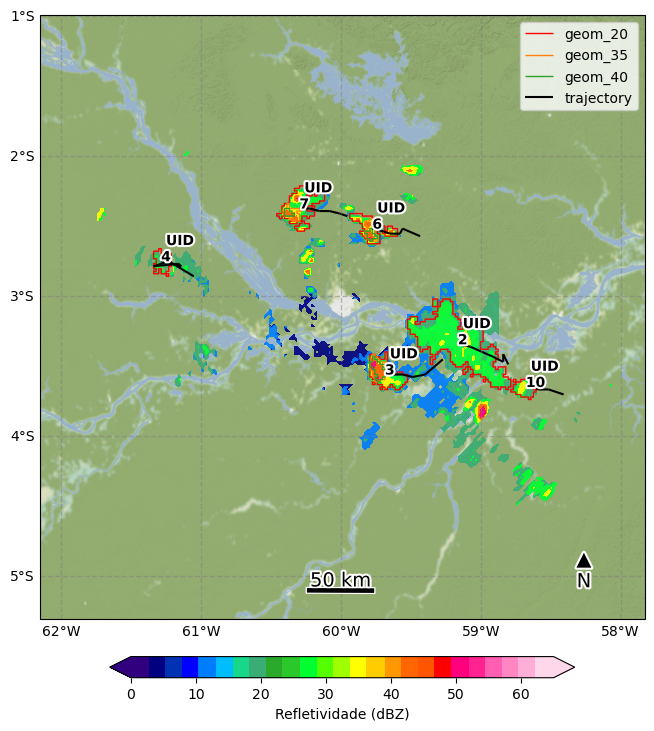

In [108]:
plot(df_filter1,5)

In [109]:
import plotly.express as px
import plotly.graph_objects as go

In [110]:
geo_cols = []
for c in df_filter1.columns:
    if 'geom_' in c or 'line' in c or 'traj' in c or 'vect' in c:
        geo_cols.append(c)

In [111]:
no_geo_cols = [item for item in df_filter1.columns if item not in geo_cols]

In [112]:
geo_df = gpd.GeoDataFrame(df_filter1)
geo_df['geometry'] = df_filter1['geom_20'].apply(wkt.loads)

In [113]:
geo_df.query('time <= 5')

timestamp  time  uid  id_t       lat        lon     p0  \
Fam_0  0   2014-09-07 00:00:00     0    0     2 -3.866008 -58.262753  216.0   
       10  2014-09-07 00:12:00     1    0     3 -3.884098 -58.334747  212.0   
Fam_1  1   2014-09-07 00:00:00     0    1     5 -3.759429 -59.199203  164.0   
       11  2014-09-07 00:12:00     1    1     4 -3.795402 -59.253189  161.0   
Fam_10 20  2014-09-07 00:24:00     2   10     8 -3.668817 -58.515167  202.0   
       28  2014-09-07 00:36:00     3   10     5 -3.668921 -58.587177  198.0   
       35  2014-09-07 00:48:00     4   10     8 -3.651007 -58.623211  196.0   
       41  2014-09-07 01:00:00     5   10    10 -3.651080 -58.677219  193.0   
Fam_2  2   2014-09-07 00:00:00     0    2     6 -3.489554 -58.803436  186.0   
       13  2014-09-07 00:12:00     1    2    10 -3.417735 -58.839520  184.0   
       22  2014-09-07 00:24:00     2    2    10 -3.471631 -58.839458  184.0   
       30  2014-09-07 00:36:00     3    2     8 -3.435780 -58.911495  180.0   
       37  2014-09-07 00:48:00     4    2    11 -3.364077 -59.073547  171.0   
       43  2014-09-07 01:00:00     5    2    13 -3.346188 -59.163548  166.0   
Fam_3  3   2014-09-07 00:00:00     0    3     8 -3.454065 -59.271454  160.0   
       12  2014-09-07 00:12:00     1    3     7 -3.561943 -59.397377  153.0   
       21  2014-09-07 00:24:00     2    3     9 -3.579958 -59.487373  148.0   
       29  2014-09-07 00:36:00     3    3     6 -3.562026 -59.559387  144.0   
       36  2014-09-07 00:48:00     4    3    10 -3.562054 -59.631390  140.0   
       42  2014-09-07 01:00:00     5    3    12 -3.562072 -59.685394  137.0   
Fam_4  4   2014-09-07 00:00:00     0    4    25 -2.860910 -61.052738   61.0   
       14  2014-09-07 00:12:00     1    4    20 -2.752928 -61.232506   51.0   
       24  2014-09-07 00:24:00     2    4    23 -2.788729 -61.340473   45.0   
       32  2014-09-07 00:36:00     3    4    14 -2.770973 -61.160580   55.0   
       38  2014-09-07 00:48:00     4    4    17 -2.788957 -61.142609   56.0   
       44  2014-09-07 01:00:00     5    4    24 -2.752866 -61.286469   48.0   
Fam_5  5   2014-09-07 00:00:00     0    5    26 -2.519303 -61.304192   47.0   
       15  2014-09-07 00:12:00     1    5    23 -2.519194 -61.394108   42.0   
       25  2014-09-07 00:24:00     2    5    25 -2.555145 -61.376167   43.0   
Fam_6  6   2014-09-07 00:00:00     0    6    27 -2.573832 -59.433899  151.0   
       16  2014-09-07 00:12:00     1    6    24 -2.519990 -59.559811  144.0   
       46  2014-09-07 01:00:00     5    6    28 -2.520052 -59.775608  132.0   
       39  2014-09-07 00:48:00     4    6    21 -2.520049 -59.757626  133.0   
       33  2014-09-07 00:36:00     3    6    18 -2.555953 -59.649715  139.0   
       26  2014-09-07 00:24:00     2    6    26 -2.555929 -59.577782  143.0   
Fam_7  7   2014-09-07 00:00:00     0    7    28 -2.430241 -59.955444  122.0   
       17  2014-09-07 00:12:00     1    7    25 -2.412275 -60.009392  119.0   
       27  2014-09-07 00:24:00     2    7    28 -2.394305 -60.081318  115.0   
       34  2014-09-07 00:36:00     3    7    21 -2.394297 -60.153244  111.0   
       40  2014-09-07 00:48:00     4    7    24 -2.376319 -60.225166  107.0   
       47  2014-09-07 01:00:00     5    7    30 -2.376302 -60.297089  103.0   
Fam_8  8   2014-09-07 00:00:00     0    8    29 -2.411828 -58.984432  176.0   
       18  2014-09-07 00:12:00     1    8    26 -2.411918 -59.092323  170.0   
Fam_9  9   2014-09-07 00:00:00     0    9    33 -2.214208 -58.984589  176.0   
       19  2014-09-07 00:12:00     1    9    32 -2.196195 -58.930668  179.0   

              p1  size_20  mean_ref_20  ...  \
Fam_0  0    80.0     66.0    35.540233  ...   
       10   79.0     34.0    26.850009  ...   
Fam_1  1    86.0     75.0    39.058735  ...   
       11   84.0     41.0    37.308171  ...   
Fam_10 20   91.0     82.0    38.440909  ...   
       28   91.0     93.0    39.537189  ...   
       35   92.0     72.0    39.452136  ...   
       41 

In [114]:
gd_t = geo_df.query('time == 5')

In [115]:
gd_t = gd_t.reset_index()

In [116]:
def ncdf(nc_file):
    ## OPEN RADAR DATA COMPRESS
    with gzip.open(nc_file) as gz:
        with netCDF4.Dataset('dummy', mode='r', memory=gz.read()) as nc:
            data = nc.variables[VAR][0][LEVEL][:].filled()
            lon = nc.variables['lon0'][:].filled()
            lat = nc.variables['lat0'][:].filled()
    return data,lon,lat

data_,lon_,lat_ = ncdf(gd_t.nc_file.iloc[0])

In [117]:
data_[data_ == -9999] = np.nan

In [118]:
img_pts,lons,lats = [],[],[]

for i in range(len(data_)):
    for j in range(len(data_)):
        if data_[i][j] != np.nan:
            img_pts.append(data_[i][j])
            lons.append(lon_[i][j])
            lats.append(lat_[i][j])
            
img_df = pd.DataFrame(list(zip(lons,lats,img_pts)),
               columns =['lon','lat','metric'])

In [119]:
import datashader.transfer_functions as tf
from colorcet import rainbow
import datashader as ds
import json

cvs = ds.Canvas(plot_width=data_.shape[0], plot_height=data_.shape[1])
agg = cvs.points(img_df, x='lon', y='lat')
coords_lat, coords_lon = agg.coords['lat'].values, agg.coords['lon'].values

# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

In [306]:
np.nanmin(agg.values)

-10.434811

In [301]:
# data_[data_ <= 20 ] = np.nan

agg.values = data_
img = tf.shade(agg, cmap=complet_rbb['HEX'].tolist(),alpha=255)[::-1].to_pil()

In [151]:
from colormap import rgb2hex

In [293]:
np.nanmin(data_)

-10.434811

In [ ]:
map(int, results)

In [280]:
tab = pd.read_table('../stanalyzer/cpt/NEXRAD.cpt',sep=';',names=['RGB','DBZ'])
tab['HEX'] = tab['RGB'].apply(lambda x: rgb2hex(int(x.split(",")[0]),int(x.split(",")[1]),int(x.split(",")[2])))

In [281]:
tab2 = pd.DataFrame(columns=['RGB','DBZ','HEX'])

tab2['DBZ'] = np.arange(-186,-30)
tab2['HEX'] = ['#000000'] * len(tab2['DBZ'])
tab2['RGB'] = ['0, 0, 0'] * len(tab2['DBZ'])

In [283]:
complet_rbb = pd.concat([tab2,tab])

In [308]:
complet_rbb

,RGB,DBZ,HEX
0,"0, 0, 0",-186,#000000
1,"0, 0, 0",-185,#000000
2,"0, 0, 0",-184,#000000
3,"0, 0, 0",-183,#000000
4,"0, 0, 0",-182,#000000
...,...,...,...
95,"141,255,255",66,#8DFFFF
96,"154,255,255",67,#9AFFFF
97,"166,255,255",68,#A6FFFF
98,"179,255,255",69,#B3FFFF


In [307]:
CMAP

In [303]:
complet_rbb['HEX'].tolist()

['#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#000000',
 '#0

In [302]:
rainbow

['#0034f8',
 '#0037f6',
 '#003af3',
 '#003df0',
 '#003fed',
 '#0041ea',
 '#0044e7',
 '#0046e4',
 '#0048e1',
 '#004ade',
 '#004cdb',
 '#004fd8',
 '#0051d5',
 '#0053d2',
 '#0054d0',
 '#0056cd',
 '#0058ca',
 '#005ac7',
 '#005cc4',
 '#005ec1',
 '#0060be',
 '#0061bb',
 '#0063b8',
 '#0065b6',
 '#0066b3',
 '#0068b0',
 '#006aad',
 '#006baa',
 '#006da7',
 '#006ea5',
 '#006fa2',
 '#00719f',
 '#00729d',
 '#00739a',
 '#007598',
 '#007695',
 '#077793',
 '#0d7890',
 '#13798e',
 '#187a8b',
 '#1c7b89',
 '#1f7c87',
 '#237d84',
 '#267e82',
 '#287f7f',
 '#2b807d',
 '#2d817b',
 '#2f8278',
 '#318376',
 '#328473',
 '#348571',
 '#35866f',
 '#36876c',
 '#37886a',
 '#388967',
 '#398a65',
 '#3a8b62',
 '#3b8c60',
 '#3c8e5d',
 '#3c8f5b',
 '#3d9058',
 '#3d9155',
 '#3e9253',
 '#3e9350',
 '#3e944d',
 '#3e954a',
 '#3e9647',
 '#3f9745',
 '#3f9842',
 '#3e993e',
 '#3e9a3b',
 '#3e9b38',
 '#3e9c35',
 '#3e9d32',
 '#3e9e2e',
 '#3e9f2b',
 '#3fa027',
 '#3fa124',
 '#40a221',
 '#41a31d',
 '#42a41a',
 '#44a517',
 '#45a615',
 '#4

In [88]:
geo1 = json.loads(gpd.GeoSeries(gd_t['geom_20'].apply(wkt.loads)).to_json())
geo2 = json.loads(gpd.GeoSeries(gd_t['geom_35'].apply(wkt.loads)).to_json())
geo3 = json.loads(gpd.GeoSeries(gd_t['geom_40'].apply(wkt.loads)).to_json())
traj = json.loads(gpd.GeoSeries(gd_t['trajectory'].apply(wkt.loads)).to_json())

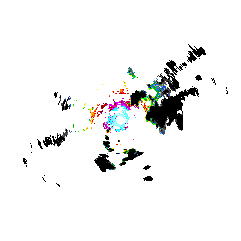

In [300]:
img

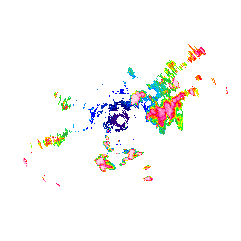

In [102]:
img

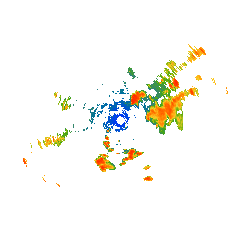

In [69]:
img

In [1]:
layers1 = [              
         {'source': geo1,
           'type': "line",
           'color': "black",
           'line':dict(width=1.5)
         },
    
         {'source': geo2,
           'type': "line",
           'color': "royalblue",
           'name':'ds',
           'line':dict(width=0.8)
          },
    
        {'source': geo3,
           'type': "line",
           'color': "red",
           'name':'ds',
           'line':dict(width=0.8)
          },
    
        {'source': traj,
           'type': "line",
           'color': "red",
           'name':'ds',
           'line':dict(width=1.8)
          },
    
        {"sourcetype": "image",
          'below': "traces",
          "source": img,
          "coordinates": coordinates,
        }
        ]

NameError: name 'geo1' is not defined

In [90]:
colorbar=dict(thickness=20,
                           ticklen=3, tickcolor='orange',
                           tickfont=dict(size=14, color='orange'))

showscale=True,
colorscale=[[0, 'green'],[1, 'red']],
cmin=0,
cmax=10


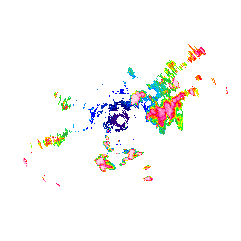

In [317]:
mapbox_access_token = 'pk.eyJ1Ijoic3BsaW50ZXJzdG0iLCJhIjoiY2tydWxjMzdlMTRxYTJwcGZlYmc0aWJyYSJ9.3-nO2w18a1fbjmAXrH7kEA'

hover_info = dict(bgcolor="white",
                font_size=14,
                font_family="Rockwell")

hover_temp = "<b>%{customdata[0]} </b><br><br>" + \
             "longitude: %{lon}<br>" + \
             "latitude: %{lat}<br>" + \
             "UID: %{customdata[1]}<extra></extra>"

### FIGURE
data = go.Scattermapbox(customdata=gd_t[['timestamp','uid','time']],
                        lat=list(gd_t["lat"]), lon=list(gd_t["lon"]),
                        textfont=dict(size=16, color='black'),
                        hoverlabel=hover_info,
                        mode='markers',
                        marker=dict(size=10, color='black',
                                showscale=True,colorscale=[[0, 'green'],[1, 'red']],cmin=0,cmax=50,
                                colorbar=dict(thickness=20,
                                   ticklen=3, tickcolor='orange',
                                   tickfont=dict(size=14, color='orange'))),
                        hovertemplate = hover_temp,
                      )

layout = dict(margin=dict(l=0, t=0, r=0, b=0, pad=0),
              mapbox=dict(layers=layers1,
                          accesstoken=mapbox_access_token,
                          center=dict(lat=-3.14, lon=-60),
                          style='light',
                          zoom=6),
              
             )

fig = go.Figure(data=data, layout=layout)

fig.update_mapboxes()

fig.show()

In [ ]:
fig = go.Figure()

fig = px.scatter_mapbox(gd_t, lat="lat", lon="lon", hover_name="uid", hover_data=["time", "uid","max_ref_20"],
                        color_discrete_sequence=["fuchsia"],width=900, height=700)

fig.update_layout(mapbox=dict(layers=layers,
                  style="stamen-terrain",
                  center =  {'lon': -60, 'lat': -3.14},
                  zoom = 6))

# buttons for updatemenu
buttons = [dict(method='restyle',
                label='linear',
                visible=True,
                args=[{'label': 'linear',
                       'visible':[True, False],}]),
           
           dict(method='restyle',
                label='sqrt',
                visible=True,
                args=[{'label': 'linear',
                       'visible':[False, True],}])]

# specify updatemenu        
um = [{'buttons':buttons, 'direction': 'down'}]

fig.update_layout(updatemenus=um)
fig.show()

In [ ]:
fig.update_layout(
    updatemenus=[
            dict(
            buttons=list([
                dict(label="High",
                     method="update",               
                     args=[{"visible": [False]},
                          {"shapes": layers1[3]}])
            ]),
                
            type = "buttons",
            direction="right",
            pad={"r": 0, "t": 0},
            showactive=True,
            x=0.38,
            xanchor="left",
            y=1,
            yanchor="top"
            )
    ])

In [ ]:
width=800, height=400

In [ ]:
fig = px.density_mapbox(img_df,lat="lat", lon="lon",z='metric',radius=5)

fig.update_layout(mapbox=dict(layers=layers,
                  style="stamen-terrain",
                  center =  {'lon': -60, 'lat': -3.14},
                  zoom = 6
                  ),
                 )

fig.update_layout(mapbox=dict(layers=layers,
                  style="stamen-terrain",
                  center =  {'lon': -60, 'lat': -3.14},
                  zoom = 6
                  ),
                 )

In [ ]:
x_states = []
y_states = []

for i,row in gd_t.iterrows():
    x = row.geometry.exterior.xy[0].tolist()
    y = row.geometry.exterior.xy[0].tolist()
    for segment in range(len(x)):
        x_states = x_states + x
        y_states = y_states + y

In [ ]:
state_trace = [dict(
            type = 'scatter',
            legendgroup = "States",
            line = dict(color='white', width=1),
            x = x_states,
            y = y_states,
            hoverinfo='none',
            showlegend=False,
            mode='lines')]

In [52]:
dir(go.Choroplethmapbox)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_repr_for_class',
 '_dispatch_change_callbacks',
 '_dispatch_on_click',
 '_dispatch_on_deselect',
 '_dispatch_on_hover',
 '_dispatch_on_selection',
 '_dispatch_on_unhover',
 '_get_child_prop_defaults',
 '_get_child_props',
 '_get_prop_validator',
 '_get_validator',
 '_in_batch_mode',
 '_init_child_props',
 '_init_props',
 '_mapped_properties',
 '_parent_path_str',
 '_path_str',
 '_process_kwargs',
 '_prop_defaults',
 '_prop_descriptions',
 '_prop_set_child',
 '_props',
 '_raise_on_invalid_property_error',
 '_relayout_child',
 '_restyle_child',
 '_send_pr

In [39]:

fig = go.Figure(go.Choroplethmapbox(geojson=gd_t.geometry,
                                    locations=gd_t.index,
                                    z=gd_t.uid,
                                    colorscale='Viridis',
                                    zauto=True,
                                    marker_opacity=0.5,
                                    marker_line_width=0.5)
                )
# fig.update_layout(mapbox_style='white-bg',
#                   #mapbox_accesstoken=mapbox_token,
#                   mapbox_zoom=12,
#                   mapbox_center={'lat': 45.41117, 'lon': -75.69812})
# fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0})
# pio.renderers.default = 'browser'
fig.show()

TypeError: Object of type Polygon is not JSON serializable

In [41]:
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,AFG,4
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,AFG,4
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,AFG,4
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,AFG,4
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,AFG,4
...,...,...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306,ZWE,716
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,ZWE,716
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,ZWE,716
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,ZWE,716


In [43]:
import plotly.express as px

df = px.data.gapminder()
fig = px.choropleth(df, locations="iso_alpha",
                    color="lifeExp", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                    animation_frame='year')

# fig2 = px.scatter_geo(df, locations="iso_alpha",
#                     size="lifeExp", # lifeExp is a column of gapminder
#                     hover_name="country", # column to add to hover information
#                     color_continuous_scale=px.colors.sequential.Plasma,
#                     animation_frame='year')
fig.add_trace(fig2.data[0])

# for i, frame in enumerate(fig.frames):
#     fig.frames[i].data += (fig2.frames[i].data[0],)
fig.show()

In [ ]:
!conda install -c plotly plotly_express -y

In [ ]:
open_ncdf(df_filter1['nc_file'].iloc[0])

In [ ]:
from shapely import wkt
import numpy as np

In [ ]:
fam_test = df_filter1.query('uid == 118')
fam_test['geom_35'].fillna(value='GEOMETRYCOLLECTION EMPTY', inplace=True)


geo_frame = gpd.GeoDataFrame()
geo_frame['geometry'] = fam_test['geom_35'].apply(wkt.loads)

In [ ]:
geo_frame.tail(2).plot()

In [ ]:
fam_test['geom_35'].apply(wkt.loads)

In [ ]:
tt = gpd.GeoDataFrame()
tt['geometry'] = fam_test['geom_intersect'].apply(wkt.loads)

In [ ]:
tt.plot()

In [ ]:
import geopandas as gpd

In [ ]:
### PATH
PATH_FILE = '../tracks/S201409070000_E201409100000_VDBZc_T20_L5.pkl'

In [ ]:
### Read tracking file
df = sta.read_file(PATH_FILE)
df.head()

In [ ]:
sta.life_cicle()

In [ ]:
life_cicle(df)

In [ ]:
# Dataframe library
import pandas as pd
# Numerical Python library
import numpy as np
# netCDF4 library
import netCDF4
# Import gzip to open netCDF
import gzip
# Visualization library
import matplotlib.pyplot as plt

## Variables

**Fam_Nº**-> Refers to the number of the Tracked Family.
<br>

**timestamp** ->A digital record of the time of occurrence of a particular event.
<br>
**time** -> Refers to the tracking time in the algorithm.
<br>
**uid** -> Unique IDentifier, it is used to generate the families.
<br>
**id_t** -> Referring cluster identifier at the time of tracking occurrence. From the DBSCAN clustering algorithm.
<br>
**lat** -> Refers latitude centroid, taken from the reference matrix of the original nc files.
<br>
**lon** -> Refers longitude centroid, taken from the reference matrix of the original nc files.
<br>
**p0** -> The first coordinate point of centroid in matrix (clusters or nc_file): (p0,p1)=(x,y)=(lon,lat).
<br>
**p1** -> The second coordinate point of centroid in matrix (clusters or nc_file): (p0,p1)=(x,y)=(lon,lat).
<br>
**size_%THRESHOLD** -> Total number of Pixels in the main cluster. Each point depends on the sensor's spatial resolution (pixel size): RADAR 2x2km.
<br>
**mean_ref_%THRESHOLD** -> Averaged reflectivity of the cluster. Value in dBZ.
<br>
**max_ref_%THRESHOLD** -> Max reflectivity of the cluster. Value in dBZ.
<br>
**angle_%THRESHOLD_orig** -> Original displacement angle of the cluster at the current time.
<br>
**angle_%THRESHOLD_cor** -> Corrected displacement angle of the cluster at the current time. 
<br>
**vel_%THRESHOLD_orig** -> Original displacement velocity of the cluster at the current time in kilometers per hour (km/h).
<br>
**vel_%THRESHOLD_cor** -> Corrected displacement velocity of the cluster at the current time in kilometers per hour (km/h).
<br>
**mean_total_ref_%THRESHOLD** -> Average reflectivity of the inner clusters by threshold (Value in dBZ).
<br>
**total_size_%THRESHOLD** -> Total size of inner clusters by threshold (number of pixels).
<br>
**n_cluster_%THRESHOLD** -> Total number of inner clusters by Threshold.
<br>
**avg_angle_%THRESHOLD** -> Averaged angle for the inner cluster by threshold (Value in degree).
<br>
**avg_vel_%THRESHOLD** -> Averaged velocity for inner clusters by threshold (Value in km/h).
<br>
**status** -> Status of occurrence, type: NEW-> New cluster; CONT-> Continous cluster; SPLT -> Splitted cluster; MERG -> Merged Cluster.
<br>
**delta_t** -> Time interval for cluster life cycle.
<br>
**nc_file** -> Path of netCDF file.
<br>
**cluster_file** -> Path of cluster file (From DBSCAN).
<br>
**dsize_%THRESHOLD** -> Difference between the sizes of two consecutive clusters (in Pixel).
<br>
**dmean_ref_%THRESHOLD** -> Difference between the mean reflectivities of two consecutive clusters for main threshold (in dBZ).
<br>
**dmean_total_ref_%THRESHOLD** -> Difference between the mean reflectivities of all clusters between two consecutive times for an inner threshold (in dBZ).
<br>
**dtotal_size_%THRESHOLD** -> Difference between the total size (in pixel) of all clusters between two consecutive times for an inner threshold (values in pixel).

## Read tracking file

Tracking DataFrame.

In [ ]:
fam_tracking = pd.read_pickle("./S201409070000_E201409100000_VDBZc_T20_L5.pkl")
fam_tracking

### Example how to select a FAM by uid

In [ ]:
uid = 97
selected_fam = fam_tracking.query('uid == @uid')
selected_fam

## Example how to select a cluster in the family

In [ ]:
line = 0 #first line 

selected_line = selected_fam.iloc[[line]]
selected_line

## Example how to open the cluster file and the original data to extract reflectivity values

In [ ]:
## OPEN CLUSTERS
def open_cluster(path):
    try:
        cluster = np.load(path['cluster_file'].values[0])['arr_0']
        cluster[cluster == 0] = np.NAN
        return cluster
    except:
        print('File not found!')

In [ ]:
selected_line

In [ ]:
cluster_matrix_all = open_cluster(selected_line)
print('Original dimensions of cluster->',cluster_matrix_all.shape)

THRESHOLD_LEVEL = 0 #to select the main threshold (ex: 0-20dBZ,1-35dBZ,2-40dBZ)
cluster_matrix = cluster_matrix_all[:,:,THRESHOLD_LEVEL]
print('Selected dimensions of cluster->',cluster_matrix.shape)

In [ ]:
### OPEN NETCDF
def open_file(file_path):
    VAR_NAME = 'DBZc'
    LEVEL = 5 #2.5km height
    THRESHOLDS = [20,35,40] #dBZ
    with gzip.open(file_path['nc_file'].values[0]) as gz:
        with netCDF4.Dataset('dummy', mode='r', memory=gz.read()) as nc:
            data = nc.variables[VAR_NAME][0][LEVEL][:].filled()
            data[data == -9999.] = np.NAN
    data[data < THRESHOLDS[0]] = np.nan
    return data

In [ ]:
nc_matrix = open_file(selected_line)
print('NetCDF Max/Min values (thresholded):\n',np.nanmax(nc_matrix),np.nanmin(nc_matrix))

In [ ]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(15,6))

ax.imshow(nc_matrix)
ax1.imshow(cluster_matrix);
ax.set_title('Original file')
ax1.set_title('Cluster file');

## Extracting reflectivities from the selected cluster

To extract the reflectivity values of an individual cluster, you will need to choose the tracking 'id_t', this should be done as follows:

Visualization of individual line.

In [ ]:
selected_line

In [ ]:
### This line shows that id_t is equal to 20. 
selected_id_t = selected_line.id_t.values[0]

### Get XY coordinates from cluster matrix
x,y = np.where(cluster_matrix == selected_id_t)

### Get reflectivities values from nc_file cluster
dbz_list = nc_matrix[x,y]

In [ ]:
print('List with reflectivity values of an individual cluster.\n',dbz_list)

### Cluster location view

In [ ]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(15,6))
ax.imshow(nc_matrix)
ax1.imshow(cluster_matrix);
ax.set_title('Original file')
ax1.set_title('Cluster file');

ax.scatter(selected_line.p0,selected_line.p1,marker='x',color='r',s=100)
ax1.scatter(selected_line.p0,selected_line.p1,marker='x',color='r',s=100)